# Wavemap clusters

author: laquitainesteeve@gmail.com

Validate action potential shapes with WaveMap clustering for biophysical evoked neuropixel demo.

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz) with RTX 5090 GPU with 40GB VRAM (GPU not needed)

Execution time: 2 mins

Required resources:

- RAM: 184 GB

Method: 

- selected sorted single-units only
- traces are whitened to increasing denoising (as in Kilosort)
- PEAK_SIGN is 'neg' rather than 'both' when generating templates to find the nearest site.
- aligned each sorted unit waveforms based on their negative peak (trough) searched in a short window of 2.5 ms surrounding the trough, to prevent waveform collisions.
- wavemap louvain clustering set to resolution 1.5 (as in wavemap paper) instead of default 1.
- we removed clusters with less than 5 units


## Setup

Prerequisites:

1. Setup "_envs/demo.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name demo --display-name "demo"_
3. Download with notebooks/1_results/0_download_recordings.ipynb and 0_download_sortings.ipynb




In [866]:
%%time
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import packages
import os
import shutil
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
from spikeinterface import extract_waveforms
import spikeinterface.core.template_tools as ttools
from spikeinterface.core.sparsity import compute_sparsity
from matplotlib import pyplot as plt;
import multiprocessing
import torch
import pandas as pd
import seaborn as sns
import matplotlib
import sys
from scipy.stats import kruskal
import scikit_posthocs as sp
import sklearn
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp # set context "fork" for macOS or "spawn"
import random 
from umap import umap_ as umap
import networkx as nx
import community as community_louvain
from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

print("spikeinterface version:", si.__version__)

# project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(proj_path)

# import spikebias package
from src.nodes.utils import get_config, demean
from src.nodes.validation import snr
from src.nodes.validation import amplitude, power_demo, power


# setup dataset paths
# npx_spont
RECORDING_NS_PATH = 'dataset/00_raw/recording_npx_spont'
SORTING_NS_KS3_PATH = 'dataset/01_intermediate/sorting/npx_spont/SortingKS3'

# npx_evoked
RECORDING_E_PATH = 'dataset/00_raw/recording_npx_evoked'
SORTING_E_KS3_PATH = 'dataset/01_intermediate/sorting/npx_evoked/SortingKS3'

# Marques-Smith
RECORDING_MS_PATH = 'dataset/00_raw/recording_marques_smith'
SORTING_MS_KS3_PATH = 'dataset/01_intermediate/sorting/marques/SortingKS3'

# setup recording preprocessing parameters
#DURATION_SEC = 1800        # TO TEST (the longer the more choice of quality waveforms for curation and template computing) 
FREQ_MIN = 300
FREQ_MAX = 3000            # TO TEST (the higher and the more resolution to find fast spiking waveforms, but the more noise)
REFERENCE = "global"       # common reference preprocessing
OPERATOR = "median"        # common reference preprocessing


# setup waveforms parameters
PEAK_SIGN = "neg"
METHOD = 'radius'          # compute sparse waveforms within radius of the nearest electrode
RADIUS_UM = 40             # compute sparse waveforms radius
# EXT_PARAMS = {'waveforms': {'ms_before': 6.0, 'ms_after': 6.0}, 
#               'templates': {'operators': ['average', 'std'], 'ms_before': 6.0, 'ms_after': 6.0},
#               'random_spikes': {'seed': 0}}
EXT_PARAMS = {'waveforms': {'ms_before': 3, 'ms_after': 3},                                   # TEST shorter waveforms (less variability) 
              'templates': {'operators': ['average', 'std'], 'ms_before': 3, 'ms_after': 3},  # TEST shorter templates (less variability) 
              'random_spikes': {'max_spikes_per_unit': 1e6, 'seed': 0}}                      # TEST more waveforms

WAVE_PATH = os.path.join(proj_path + "temp/waveforms/npx_spont/SortingKS3")
N_JOBS = 20                 # (default = 20) number of parallel processes for waveform extraction (20/32)
CHUNKS = 50000              # (default = 800000) use smaller chunks to use less RAM
JOB_KWARGS = dict(n_jobs=N_JOBS, chunk_size=800000, progress_bar=True)   # 20/32 cores

# setup template parameters
# these make the average waveform (template) more robust to outlier waveforms
# and more representative to the majority of observed waveforms
ABS_DEV = 0.4        # (default=0.4) as in lee et al 2021's wavemap paper - heuristic curation of single-units
N_STD_OF_MEAN = 2    # (default=2) as in lee et al 2021's wavemap paper - heuristic curation of single-units



# wavemap parameters
RAND_STATE = 4
N_NEIGHBORS = 15
N_SITES = 4

colors = np.array( # waveform shape profile colors
    [
        [0.9, 0.7, 0.3],  # yellow/gold
        [0.8, 0.70, 0.2],  # lighter yellow/green
        [0.8, 0.75, 0.2],  # lightest yellow/green
        [1, 0, 0],  # red
        [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        [0.64, 0.85, 0.99],  # lightest blue
        [254 / 255, 235 / 255, 226 / 255],  # purple variation
        [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
        [247 / 255, 104 / 255, 161 / 255],  # purple variation
        [221 / 255, 52 / 255, 151 / 255],  # purple variation
        [174 / 255, 1 / 255, 126 / 255],  # purple variation
        [100 / 255, 1 / 255, 126 / 255], 
        [50 / 255, 1 / 255, 126 / 255],  
        [50 / 255, 10 / 255, 126 / 255],  
        [50 / 255, 10 / 255, 50 / 255],  
        [1, 0.5, 0], 
        [0, 0.5, 1]
    ]
)

# plot parameters
FIG_SIZE = (1.5, 1.5)
cl = dict()
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_MEDIAN"] = (1, 0.76, 0)

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 14  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":400}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface version: 0.101.2
CPU times: user 621 μs, sys: 0 ns, total: 621 μs
Wall time: 582 μs


## clear RAM

In [723]:
# clear RAM
import getpass; password = getpass.getpass("Enter your sudo password: ")
!sync; echo {password} | sudo -S sh -c 'echo 1 > /proc/sys/vm/drop_caches'

[sudo] password for steeve: 

## Functions

In [829]:
def get_nearest_site(templates_by_site):
    trough_amplitude = np.nanmin(templates_by_site, axis=1)
    
    # catch exception
    if np.isnan(trough_amplitude).all():
        index = None
    else: 
        index = np.nanargmin(np.nanmin(templates_by_site, axis=1))        
    return index


def get_waveforms_for(cell_id, waveform_extension):
    return waveform_extension.get_waveforms_one_unit(unit_id=cell_id)


def align_by_neg_peak_and_crop(waves, sampling_frequency, window_to_search_peak_sec=2.5, window=100, peak_pos=50):
    """
    W: array of shape (n_waveforms, n_samples) e.g. (N, 480)
    window: number of samples in the output window (e.g. 100)
    peak_pos: index in [0, window-1] where the negative peak will be placed (e.g. 50)
    fill_value: value used when the 100-sample window would run beyond the edges
    Returns: array of shape (n_waveforms, window)
    """
    
    # find peak index in shortened waveform
    # shorten waveform to find peak without spike collision
    short_waves, wind_start, wind_end = shorten_waveform(waves, window_to_search_peak_sec=window_to_search_peak_sec, sampling_freq=sampling_frequency)

    num_waves, _ = short_waves.shape
    left = peak_pos
    right = window - left  # number of samples to include to the right of the peak
    aligned = np.full((num_waves, window), np.nan, dtype=short_waves.dtype) # placeholder of nans

    # index of negative peak for each waveform
    trough_idx = np.argmin(short_waves, axis=1)

    # locate peak index in longer waveforms
    trough_idx = trough_idx + wind_start

    # number of timepoints in longer waves
    n_timepoints = waves.shape[1]

    for w_ix in range(num_waves):

        # desired window in original signal: [p-left, p+right)
        src_start = max(0, trough_idx[w_ix] - left)
        src_end   = min(n_timepoints, trough_idx[w_ix] + right)
        
        # where to place it in the output (shift if we clipped at edges)
        dst_start = max(0, left - trough_idx[w_ix])          # how many samples we clipped on the left
        dst_end   = dst_start + (src_end - src_start)

        # align
        aligned[w_ix, dst_start:dst_end] = waves[w_ix, src_start:src_end]
    return aligned


def shorten_waveform(waveforms: np.array, window_to_search_peak_sec=2.5, sampling_freq=40000):

    # calculate shorter window
    sample_sec = (1/sampling_freq) * 1000
    shorter_window = int(window_to_search_peak_sec / sample_sec)

    # get shorter window
    mid_point = int(waveforms.shape[1] / 2 )
    wind_start = int(mid_point - shorter_window/2)
    wind_end =  int(mid_point + shorter_window/2)
    shorter_window_sample = np.arange(wind_start, wind_end, 1).astype(int)
    return waveforms[:, shorter_window_sample], wind_start, wind_end


def get_single_unit_ids(Sorting):
    single_unit_ix = np.where(Sorting.get_property('KSLabel') == 'good')[0]
    return Sorting.unit_ids[single_unit_ix]


def filter_best_set_of_waves_for_the_mean(waves, n_std_of_mean=2, abs_dev=0.4):
    """see wavemap paper 
    DOI: https://doi.org/10.7554/eLife.67490

    Args:    
        waves (np.array): (n_waveforms, n_timepoints)
        
    Returns:
        selected_waves
        selected_indices
    """

    
    # mean and per-time-point std of the waveforms
    mean_wave = np.nanmean(waves, axis=0)
    std_wave = np.nanstd(waves, axis=0)  # ddof=0 (population). Use ddof=1 if you prefer sample std.

    # Avoid divide-by-zero where a time point has zero variance
    std_safe = np.where(std_wave == 0, 1.0, std_wave)

    # Condition A: every time point is within ±2 std of the mean (pointwise)
    z = (waves - mean_wave) / std_safe
    within_2std = np.all(np.abs(z) <= n_std_of_mean, axis=1)

    # Condition B: average absolute deviation from the mean across time < 0.4
    avg_abs_dev = np.nanmean(np.abs(waves - mean_wave), axis=1)
    low_avg_dev = avg_abs_dev < abs_dev

    # Final selection
    mask = within_2std & low_avg_dev
    selected_indices = np.flatnonzero(mask)
    selected_waves = waves[mask]
    return selected_waves, selected_indices


def calculate_template(cell_id, analyzer, wave_ext, sfreq, peak_sign='neg', window_to_search_peak_sec=2.5, window=100, peak_pos=50, n_std_of_mean=2, abs_dev=0.4):
    """_summary_

    Args:
        cell_id (int): _description_
        analyzer (_type_): _description_
        wave_ext (_type_): _description_
        sfreq (int): recording sampling frequency
        peak_sign (str, optional): _description_. Defaults to 'neg'
        window (int): number of timepoints of produced template
        peak_pos: index of the trough in the produced template
        n_std_of_mean (int): for filtering best waveforms - see wavemap paper
        abs_dev (float): for filtering best waveforms - see wavemap paper

    Returns:
        dict: 
        - 'templates': templates for the cell's nearby sites of shape (n_sites, n_timepoints)
    """
    # get waveforms and the index of the nearest site
    waves = get_waveforms_for(cell_id, wave_ext)

    # get number of nearby sites
    _, _, n_sites = waves.shape

    templates = []

    for site_ix in range(n_sites):
        
        # align waveforms
        aligned = align_by_neg_peak_and_crop(waves[:,:,site_ix], sfreq, 
                                             window_to_search_peak_sec=window_to_search_peak_sec,
                                               window=window, peak_pos=peak_pos)

        # filter the best waveforms to calculate a reliable template
        # waveforms should be short (else high noise away from waveform prevents waveform selection)
        filtered, _ = filter_best_set_of_waves_for_the_mean(aligned, n_std_of_mean=n_std_of_mean, abs_dev=abs_dev)
        
        # calculate template
        templates.append(np.nanmean(filtered, axis=0))
    
    templates = np.array(templates)

    # get nearby site ids
    site_ids = analyzer.sparsity.unit_id_to_channel_ids[cell_id]

    # get nearest sites (found within sparse nearby sites)
    nearest_site_ix = get_nearest_site(templates)
    nearest_site_id = site_ids[nearest_site_ix]

    return {'templates': templates, 
            'nearest_site_index': nearest_site_ix, 
            'nearest_site_id': nearest_site_id, 
            'nearby_site_ids': site_ids}


def apply_wavemap(downsampled_nearest_site_templates, rand_state, n_neighbors=15, n_components=3, resolution=1.5, verbose=False):

    # setup reproducibility
    np.random.seed(rand_state)
    os.environ["PYTHONHASHSEED"] = str(rand_state)
    random.seed(rand_state)

    # normalize waveforms between -1 and 1.
    scaler = MinMaxScaler(feature_range=(-1, 1))
    normalized = scaler.fit_transform(downsampled_nearest_site_templates.T).T

    # reduce dimensionality with UMAP (defaults to 2D)
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components)
    mapper = reducer.fit(normalized)

    # clustering with Louvain
    G = nx.from_scipy_sparse_array(mapper.graph_)
    clustering = community_louvain.best_partition(G, resolution=resolution)
    clustering_solution = list(clustering.values())

    # calculate this partition's quality (modularity index)
    modularity = community_louvain.modularity(clustering, G)

    # create 2D embedding
    embedding = reducer.fit_transform(normalized)

    # label dimensions
    nb_dims = embedding.shape[1]
    dimensions = tuple(np.arange(0, nb_dims,1))

    # get cluster profiles
    umap_df = pd.DataFrame(embedding, columns=dimensions)
    umap_df["waveform"] = list(normalized)
    umap_df["cluster_id"] = clustering_solution
    profiles = np.unique(umap_df["cluster_id"])
    if verbose:
        print('nb of shape profiles:', len(profiles))
    return normalized, umap_df, profiles, modularity


def get_multi_site_templates(templates: np.array, n_sites=6):

    # get indices of n_sites (6) with the largest 
    # trough, in ascending order
    mins = np.min(templates, axis=1)
    neg_idx = np.flatnonzero(mins < 0)
    order = np.argsort(mins[neg_idx])
    sorted_indices = neg_idx[order]
    # return templates for these sites,
    # in ascending order
    return templates[sorted_indices[:n_sites],:]


def plot_embedding(ax, umap_df, profiles, colors):
    
    # plot
    for ix, profile_i in enumerate(profiles):
        ax.scatter(umap_df[0][umap_df["cluster_id"] == profile_i].tolist(),
            umap_df[1][umap_df["cluster_id"] == profile_i].tolist(),
            marker="o", color=colors[ix], label=profile_i, s=20, edgecolors='w')

    # aesthetics
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_ylabel("Feature 1 (a.u)")
    ax.set_xlabel("Feature 2 (a.u)")

    # legend
    ax.legend(fontsize=7, bbox_to_anchor=(1, 1.1), labelspacing=0.1, **{"frameon": False, "handletextpad": 0.1})
    return ax 


def plot_embedding_3D(ax, umap_df, profiles, colors):
    
    # plot
    for ix, profile_i in enumerate(profiles):
        ax.scatter(xs=umap_df[0][umap_df["cluster_id"] == profile_i].tolist(),
            ys=umap_df[1][umap_df["cluster_id"] == profile_i].tolist(),
            zs=umap_df[2][umap_df["cluster_id"] == profile_i].tolist(),
            marker="o", color=colors[ix], label=profile_i, s=10)

    # aesthetics
    ax.spines[["top", "right"]].set_visible(False)
    ax.set_xlabel("Feature 1 (a.u)")
    ax.set_ylabel("Feature 2 (a.u)")
    ax.set_zlabel("Feature 3 (a.u)")

    # legend
    ax.legend(fontsize=20, bbox_to_anchor=(1, 1.1), labelspacing=0.1, **{"frameon": False, "handletextpad": 0.1})
    return ax 


def plot_profiles(ax, normWFs, umap_df, profiles, colors, is_title=True, is_ylabel=True):

    # plot templates per shape profile
    for ix in range(len(profiles)):
        ax[ix].plot(normWFs[umap_df["cluster_id"] == ix].T, color=colors[ix], alpha=0.5, linewidth=1);
        if is_title:
            ax[ix].set_title(str(ix), fontsize=7)
        if is_ylabel:
            ax[ix].set_ylabel(str(ix), fontsize=7)
    return ax


def get_multi_site_templates_for_wavemap(templates_dict, n_sites=6, downsampling=2, scaling=True):
    
    # get multi-site templates
    multi_sites_templates = []
    unit_ids = []
    for ix, unit_id in tqdm(enumerate(templates_dict)):
        
        templates = templates_dict[unit_id]['templates']

        # catch exception
        if (templates.shape[0] >= n_sites) and (not np.isnan(templates).any()):
            tmp = get_multi_site_templates(templates, n_sites=n_sites)
            multi_sites_templates.append(tmp)
            unit_ids.append(unit_id)
    
    multi_sites_templates = np.array(multi_sites_templates) # (n_units, n_sites (=6), n_timepoints)
    multi_sites_templates = multi_sites_templates[:,:,::downsampling] # downsample waveforms to 50 timepoints

    # scale each nearby channel between -1 and 1
    if scaling:

        # create scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))

        # normalize each site's waveform between -1 and 1
        # make an array (n_units, n_sites (=6), n_timepoints)        
        normalized = []
        for ix in range(multi_sites_templates.shape[0]):
            normalized.append(scaler.fit_transform(multi_sites_templates[ix,:,:].T).T)
        multi_sites_templates = np.array(normalized) 
        
    # concatenate waveforms across sites per unit
    return multi_sites_templates.reshape(multi_sites_templates.shape[0],-1), unit_ids 


def compute_template_data(single_units, analyzer, wave_ext, sfreq, peak_sign, window_to_search_peak_sec, window_samples, peak_pos_sample, n_std_of_mean, abs_dev):
    # calculate the templates on (30) nearby sites for each unit
    templates_dict_e = dict()
    for _, unit_id in tqdm(enumerate(single_units)):
        templates_dict_e[unit_id] = calculate_template(unit_id, analyzer, wave_ext, sfreq, peak_sign=peak_sign, window_to_search_peak_sec=window_to_search_peak_sec, window=window_samples, peak_pos=peak_pos_sample, n_std_of_mean=n_std_of_mean, abs_dev=abs_dev)
    return templates_dict_e


def find_best_resolution(templates, rand_state=0, n_neighbors=15, n_components=2, resolution_range=np.arange(0.1, 5, 0.1), verbose=False):
    """
    Find the best resolution that maximizes modularity for given templates.

    Args:
        templates (np.ndarray): Input templates for clustering.
        rand_state (int): Random state for reproducibility.
        n_neighbors (int): Number of neighbors for UMAP.
        n_components (int): Number of components for UMAP.
        resolution_range (np.ndarray): Range of resolution values to test.

    Returns:
        float: Best resolution value.
        list: List of modularity values for each resolution.
    """
    modularities = []
    for resolution_i in resolution_range:
        _, _, _, modularity = apply_wavemap(templates, rand_state, n_neighbors=n_neighbors, n_components=n_components, resolution=resolution_i, verbose=verbose)
        modularities.append(modularity)
    best_resolution = resolution_range[np.argmax(modularities)]
    return best_resolution, modularities

## Load datasets

In [725]:
%%time 

# load npx_spont recordingg and sorting extractors
RecordingNS = si.load_extractor(RECORDING_NS_PATH)
#RecordingNS = RecordingNS.frame_slice(start_frame=0, end_frame=RecordingNS.sampling_frequency * DURATION_SEC)
print('Recording:', RecordingNS)

SortingNS = si.load_extractor(SORTING_NS_KS3_PATH)
#SortingNS = SortingNS.frame_slice(start_frame=0, end_frame=SortingNS.sampling_frequency * DURATION_SEC)
print('Sorting:', SortingNS)

single_units_ns = get_single_unit_ids(SortingNS)
print('nb of single units:', len(single_units_ns))
print(single_units_ns)

Recording: BinaryFolderRecording: 384 channels - 40.0kHz - 1 segments - 82,319,958 samples 
                       2,058.00s (34.30 minutes) - float32 dtype - 117.76 GiB
Sorting: npzfolder: 1684 units - 1 segments - 40.0kHz
nb of single units: 335
[ 143  201  208  215  217  221  225  227  228  232  233  235  236  244
  248  250  253  254  255  259  264  270  272  273  274  275  276  280
  285  286  288  289  290  300  302  307  309  318  321  322  325  326
  328  331  334  335  338  339  340  345  347  355  356  364  365  369
  371  378  379  380  382  384  397  399  409  411  414  418  421  426
  428  430  443  444  447  456  466  468  470  473  474  477  478  482
  488  490  497  506  510  515  517  518  519  527  532  533  540  541
  542  551  553  554  564  575  577  579  581  594  597  601  606  608
  616  620  624  639  644  650  661  673  677  684  692  694  732  735
  743  746  753  756  759  760  761  764  766  769  771  773  777  780
  781  787  788  796  797  800  810  811  

In [726]:
%%time 

# load npx_evoked recording and sorting extractors
RecordingE = si.load_extractor(RECORDING_E_PATH)
#RecordingE = RecordingE.frame_slice(start_frame=0, end_frame=RecordingE.sampling_frequency * DURATION_SEC)
print('Recording:', RecordingE)

SortingE = si.load_extractor(SORTING_E_KS3_PATH)
#SortingE = SortingE.frame_slice(start_frame=0, end_frame=SortingE.sampling_frequency * DURATION_SEC)
print('Sorting:', SortingE)

single_units_e = get_single_unit_ids(SortingE)
print('nb of single units:', len(single_units_e))
print(single_units_e)

Recording: BinaryFolderRecording: 384 channels - 20.0kHz - 1 segments - 72,359,964 samples 
                       3,618.00s (1.00 hours) - float32 dtype - 103.51 GiB
Sorting: NumpyFolder: 1660 units - 1 segments - 20.0kHz
nb of single units: 384
[  14   19   24   27   31   34   35   36   40   41   46   47   52   53
   54   56   67   68   69   70   71   72   75   76   77   83   84   87
   88   95   98  102  103  107  111  117  119  123  124  128  129  130
  133  136  139  146  157  163  165  173  174  178  179  182  189  190
  197  198  202  203  205  209  219  221  223  224  227  232  233  235
  236  237  238  241  248  256  261  267  268  269  280  285  286  287
  288  289  290  295  296  297  298  299  304  305  312  313  318  319
  341  345  346  348  350  364  367  373  376  379  387  388  391  396
  400  403  411  415  417  429  431  440  442  445  447  458  460  472
  479  481  483  490  494  507  508  509  512  526  527  528  529  547
  548  558  562  565  566  569  572  575  5

In [727]:
%%time 

# load npx_evoked recording and sorting extractors
RecordingMS = si.load_extractor(RECORDING_MS_PATH)
#RecordingMS = RecordingMS.frame_slice(start_frame=0, end_frame=RecordingMS.sampling_frequency * DURATION_SEC)
print('Recording:', RecordingMS)

SortingMS = si.load_extractor(SORTING_MS_KS3_PATH)
#SortingMS = SortingMS.frame_slice(start_frame=0, end_frame=SortingMS.sampling_frequency * DURATION_SEC)
print('Sorting:', SortingMS)

single_units_ms = get_single_unit_ids(SortingMS)
print('nb of single units:', len(single_units_ms))
print(single_units_ms)

Recording: BinaryFolderRecording: 384 channels - 30.0kHz - 1 segments - 36,451,538 samples 
                       1,215.05s (20.25 minutes) - float32 dtype - 52.14 GiB
Sorting: npzfolder: 563 units - 1 segments - 30.0kHz
nb of single units: 227
[  0   1   2   4   5   7   8   9  13  14  15  20  23  24  30  37  39  41
  43  44  47  48  52  53  56  57  58  66  70  75  77  82  87  89  98 103
 110 112 115 118 119 121 124 130 131 132 134 143 148 150 151 167 168 169
 170 184 187 189 190 191 192 199 200 201 203 209 210 211 212 214 215 228
 229 230 231 236 237 240 242 245 247 248 250 251 252 259 268 270 271 272
 273 276 281 282 284 285 287 288 289 291 294 295 298 299 300 302 306 308
 309 310 323 326 329 334 349 350 351 352 353 354 355 363 365 366 367 368
 369 373 374 375 378 379 381 391 393 397 398 400 401 403 404 405 409 412
 413 418 419 420 421 425 426 428 430 432 433 434 435 436 437 440 443 444
 445 448 449 452 468 470 471 472 477 479 483 486 488 489 490 492 493 498
 499 500 503 504 505 507

## Compute waveforms

- Execution time: 38 min for full

In [637]:
%%time 

# npx_spont

# band-pass filter, reference and whiten voltage traces (as in Kilosort)
RecordingNS = spre.bandpass_filter(RecordingNS, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
RecordingNS = spre.common_reference(RecordingNS, reference=REFERENCE, operator=OPERATOR)
RecordingNS = spre.whiten(RecordingNS, dtype='float32') # requires float

# extract waveforms for the sites within <50> um to each sorted cell
# display parameters with: analyzer.get_extension(extension_name="templates").params
AnalyzerNS = si.create_sorting_analyzer(sorting=SortingNS, recording=RecordingNS, format="memory", sparse=True)
AnalyzerNS.compute(['random_spikes', 'waveforms', 'templates'], extension_params=EXT_PARAMS, save=False)
AnalyzerNS.sparsity = compute_sparsity(templates_or_sorting_analyzer=AnalyzerNS, method=METHOD, radius_um=RADIUS_UM) # recommended method in spikeinterface
wave_ext_ns = AnalyzerNS.get_extension('waveforms')

compute_waveforms: 100%|##########| 2058/2058 [19:33<00:00,  1.75it/s]


CPU times: user 2h 45min 24s, sys: 4h 10min 32s, total: 6h 55min 57s
Wall time: 38min


- Execution time: 31 min for full

In [638]:
%%time 

# npx_evoked

# band-pass filter, reference and whiten voltage traces (as in Kilosort)
RecordingE = spre.bandpass_filter(RecordingE, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
RecordingE = spre.common_reference(RecordingE, reference=REFERENCE, operator=OPERATOR)
RecordingE = spre.whiten(RecordingE, dtype='float32')

# extract waveforms for the sites within <50> um to each sorted cell
AnalyzerE = si.create_sorting_analyzer(sorting=SortingE, recording=RecordingE, format="memory", sparse=True)
AnalyzerE.compute(['random_spikes', 'waveforms', 'templates'], extension_params=EXT_PARAMS, save=False)
AnalyzerE.sparsity = compute_sparsity(templates_or_sorting_analyzer=AnalyzerE, method=METHOD, radius_um=RADIUS_UM) # recommended method in spikeinterface
wave_ext_e = AnalyzerE.get_extension('waveforms')

estimate_sparsity:   1%|1         | 42/3618 [00:10<14:30,  4.11it/s]

compute_waveforms: 100%|##########| 3618/3618 [15:49<00:00,  3.81it/s]


CPU times: user 3h 2min 20s, sys: 5h 26min 56s, total: 8h 29min 17s
Wall time: 31min 23s


- Execution time: 16 min for full

In [728]:
%%time 

# marques-smith

# band-pass filter, reference and whiten voltage traces (as in Kilosort)
RecordingMS = spre.bandpass_filter(RecordingMS, freq_min=FREQ_MIN, freq_max=FREQ_MAX)
RecordingMS = spre.common_reference(RecordingMS, reference=REFERENCE, operator=OPERATOR)
RecordingMS = spre.whiten(RecordingMS, dtype='float32')

# extract waveforms for the sites within <50> um to each sorted cell
AnalyzerMS = si.create_sorting_analyzer(sorting=SortingMS, recording=RecordingMS, format="memory", sparse=True)
AnalyzerMS.compute(['random_spikes', 'waveforms', 'templates'], extension_params=EXT_PARAMS, save=False)
AnalyzerMS.sparsity = compute_sparsity(templates_or_sorting_analyzer=AnalyzerMS, method=METHOD, radius_um=RADIUS_UM) # recommended method in spikeinterface
wave_ext_ms = AnalyzerMS.get_extension('waveforms')

compute_waveforms: 100%|##########| 1216/1216 [08:33<00:00,  2.37it/s]


CPU times: user 1h 19min 49s, sys: 2h 7min 41s, total: 3h 27min 31s
Wall time: 16min 44s


## Compute templates

- Execution time: 2 min

In [639]:
%%time

# parameters
WINDOW = 100                   # 2.5 msecs
PEAK_POS = 50                  # 1.25 msec
WINDOW_TO_SEARCH_PEAK_SEC = 2.5 # msecs

# npx_spont
# calculate the templates on (30) nearby sites for each unit
templates_dict_ns = compute_template_data(single_units_ns, AnalyzerNS, wave_ext_ns, 
                    RecordingNS.sampling_frequency, PEAK_SIGN, WINDOW_TO_SEARCH_PEAK_SEC, 
                    WINDOW, PEAK_POS, N_STD_OF_MEAN, ABS_DEV)
# check
templates_dict_ns[single_units_ns[1]]

335it [00:13, 24.51it/s]

CPU times: user 12.3 s, sys: 1.31 s, total: 13.7 s
Wall time: 13.7 s


{'templates': array([[-3.11882287e-01, -3.97444665e-01, -3.48666936e-01,
         -1.05463415e-01,  3.76989156e-01,  1.11261833e+00,
          2.07474160e+00,  3.19563079e+00,  4.36969757e+00,
          5.46673393e+00,  6.35641956e+00,  6.92602777e+00,
          7.10196209e+00,  6.85885382e+00,  6.22772121e+00,
          5.28722334e+00,  4.15143585e+00,  2.95012856e+00,
          1.80849898e+00,  8.28562558e-01,  7.95147270e-02,
         -4.14590031e-01, -6.66761994e-01, -7.18510270e-01,
         -6.30646527e-01, -4.70490187e-01, -2.98080713e-01,
         -1.60521045e-01, -8.59647766e-02, -8.12704116e-02,
         -1.40216246e-01, -2.42466107e-01, -3.65664333e-01,
         -4.87389028e-01, -5.89656770e-01, -6.63951397e-01,
         -7.11901307e-01, -7.41711795e-01, -7.69032955e-01,
         -8.09679806e-01, -8.81807864e-01, -9.97725844e-01,
         -1.16468453e+00, -1.38036728e+00, -1.63549066e+00,
         -1.91193759e+00, -2.18686628e+00, -2.43525910e+00,
         -2.63369083e+00, -

In [730]:
%%time

# parameters
WINDOW = 50                     # 2.5 msecs
PEAK_POS = 25                   # 1.25 msec
WINDOW_TO_SEARCH_PEAK_SEC = 2.5 # msecs

# npx_evoked
templates_dict_e = compute_template_data(single_units_e, AnalyzerE, wave_ext_e, 
                    RecordingE.sampling_frequency, PEAK_SIGN, WINDOW_TO_SEARCH_PEAK_SEC, 
                    WINDOW, PEAK_POS, N_STD_OF_MEAN, ABS_DEV)

# check
np.nanmean(templates_dict_e[single_units_e[0]]['templates'], axis=0)

0it [00:00, ?it/s]

384it [00:13, 27.84it/s]

CPU times: user 13 s, sys: 815 ms, total: 13.8 s
Wall time: 13.8 s


array([ 0.08108262,  0.09278501,  0.11121216,  0.13709177,  0.16391806,
        0.18724255,  0.20751941,  0.21522774,  0.21182488,  0.20318605,
        0.19580853,  0.19540413,  0.19758248,  0.18637674,  0.15965354,
        0.11733269,  0.0672726 ,  0.03220728,  0.00969619, -0.0356228 ,
       -0.11685563, -0.25959876, -0.4502842 , -0.6544557 , -0.81948614,
       -0.8939435 , -0.8364394 , -0.7177055 , -0.57070667, -0.42982265,
       -0.32531062, -0.24321984, -0.17867386, -0.11326768, -0.05070379,
        0.01098919,  0.06462283,  0.1093936 ,  0.14563887,  0.18058755,
        0.22436315,  0.27539968,  0.33835396,  0.39208448,  0.43254218,
        0.45339385,  0.45357057,  0.4379182 ,  0.4125743 ,  0.38515413],
      dtype=float32)

In [731]:
%%time

# parameters
WINDOW = 76                     # 2.5 msecs
PEAK_POS = 38                   # 1.25 msec
WINDOW_TO_SEARCH_PEAK_SEC = 2.5 # msecs

# marques-smith
templates_dict_ms = compute_template_data(single_units_ms, AnalyzerMS, wave_ext_ms, 
                    RecordingMS.sampling_frequency, PEAK_SIGN, WINDOW_TO_SEARCH_PEAK_SEC, 
                    WINDOW, PEAK_POS, N_STD_OF_MEAN, ABS_DEV)

# check
np.nanmean(templates_dict_ms[single_units_ms[0]]['templates'], axis=0)

13it [00:00, 59.75it/s]

227it [00:09, 24.84it/s]

CPU times: user 8.67 s, sys: 475 ms, total: 9.15 s
Wall time: 9.14 s


array([ 4.3194005e-01,  4.6991101e-01,  5.0291854e-01,  5.3568554e-01,
        5.6284374e-01,  6.0167086e-01,  6.5208751e-01,  7.1127546e-01,
        7.6972973e-01,  7.9773986e-01,  8.0550992e-01,  7.8975487e-01,
        7.3780942e-01,  6.8176323e-01,  6.3248044e-01,  6.1033994e-01,
        6.2119275e-01,  6.8155789e-01,  7.6287127e-01,  8.3553183e-01,
        8.7180018e-01,  8.5557038e-01,  7.8485835e-01,  6.6808695e-01,
        5.5462044e-01,  5.0416678e-01,  5.5480778e-01,  6.9442433e-01,
        8.5706568e-01,  9.5271093e-01,  8.2950735e-01,  3.7195909e-01,
       -4.8133311e-01, -1.7122023e+00, -3.1996055e+00, -4.7361255e+00,
       -6.0658407e+00, -6.9743042e+00, -7.3081541e+00, -7.0014544e+00,
       -6.1420798e+00, -4.8988447e+00, -3.4781802e+00, -2.0937922e+00,
       -9.0071625e-01, -6.2922835e-03,  5.8840722e-01,  9.3739438e-01,
        1.1211045e+00,  1.2354257e+00,  1.3401092e+00,  1.4680636e+00,
        1.6212349e+00,  1.7864573e+00,  1.9366035e+00,  2.0594654e+00,
      

### Single-site

In [732]:
%%time

# npx_spont ------------------------------------

# get each unit's nearest site template
single_site_templates_ns = []
unit_ids_ns = []
for ix, unit_id in tqdm(enumerate(templates_dict_ns)):
    nearest_site_ix = templates_dict_ns[unit_id]['nearest_site_index']
    tmp = templates_dict_ns[unit_id]['templates'][nearest_site_ix,:]
    # catch exception
    if not np.isnan(tmp).any():
        single_site_templates_ns.append(templates_dict_ns[unit_id]['templates'][nearest_site_ix,:])
        unit_ids_ns.append(unit_id)
single_site_templates_ns = np.array(single_site_templates_ns) # (nb_units, n_timepoints)    
single_site_templates_ns = single_site_templates_ns[:,::2]    # downsample to 50 timepoints (see Wavemap paper)
print(single_site_templates_ns.shape)

# npx_evoked ------------------------------------

# get each unit's nearest site template
single_site_templates_e = []
unit_ids_e = []
for ix, unit_id in tqdm(enumerate(templates_dict_e)):
    nearest_site_ix = templates_dict_e[unit_id]['nearest_site_index']
    tmp = templates_dict_e[unit_id]['templates'][nearest_site_ix,:]
    # catch exception
    if not np.isnan(tmp).any():
        single_site_templates_e.append(templates_dict_e[unit_id]['templates'][nearest_site_ix,:])
        unit_ids_e.append(unit_id)
single_site_templates_e = np.array(single_site_templates_e) # (nb_units, n_timepoints) , no dowsampling to have same frequency as npx_spont
print(single_site_templates_e.shape)

# concatenate spont and evoked
single_site_templates = np.vstack([single_site_templates_ns, single_site_templates_e])
print('Pooled templates across spont and evoked:', single_site_templates.shape)


# marques-smith ------------------------------------

# get each unit's nearest site template
single_site_templates_ms = []
unit_ids_ms = []
for ix, unit_id in tqdm(enumerate(templates_dict_ms)):
    nearest_site_ix = templates_dict_ms[unit_id]['nearest_site_index']
    tmp = templates_dict_ms[unit_id]['templates'][nearest_site_ix,:]
    # catch exception
    if not np.isnan(tmp).any():
        single_site_templates_ms.append(templates_dict_ms[unit_id]['templates'][nearest_site_ix,:])
        unit_ids_ms.append(unit_id)
single_site_templates_ms = np.array(single_site_templates_ms) # (nb_units, n_timepoints) , no dowsampling to have same frequency as npx_spont
print(single_site_templates_ms.shape)

335it [00:00, 27918.69it/s]


(334, 50)


384it [00:00, 344589.80it/s]


(370, 50)
Pooled templates across spont and evoked: (704, 50)


227it [00:00, 306439.33it/s]

(223, 76)
CPU times: user 6.95 ms, sys: 2.01 ms, total: 8.96 ms
Wall time: 18.3 ms


### Multi-site

In [733]:
%%time

# get templates on 6 nearby sites per unit (n_units, n_timepoints x 6)
multi_sites_templates_ns, unit_ids_ns = get_multi_site_templates_for_wavemap(templates_dict_ns, N_SITES, scaling=False)
print(multi_sites_templates_ns.shape)

# get templates on 6 nearby sites per unit (n_units, n_timepoints x 6)
multi_sites_templates_e, unit_ids_e = get_multi_site_templates_for_wavemap(templates_dict_e, N_SITES, downsampling=1, scaling=False)
print(multi_sites_templates_e.shape)

# concatenate spont and evoked
multi_sites_templates = np.vstack([multi_sites_templates_ns, multi_sites_templates_e])
print('Pooled templates across spont and evoked:', multi_sites_templates.shape)

# get templates on nearby sites per unit (n_units, n_timepoints x 6)
multi_sites_templates_ms, unit_ids_ms = get_multi_site_templates_for_wavemap(templates_dict_ms, N_SITES, downsampling=1, scaling=False)
print(multi_sites_templates_ms.shape)

335it [00:00, 106140.79it/s]


(228, 200)


384it [00:00, 185127.90it/s]


(249, 200)
Pooled templates across spont and evoked: (477, 200)


227it [00:00, 181803.90it/s]

(122, 304)
CPU times: user 8.62 ms, sys: 666 μs, total: 9.29 ms
Wall time: 9.01 ms


## Wavemap

### Single-site

#### Best params

- resolution that maximizes modularity

\Spont:
2D - best resolution: 1.1
max modularity: 0.6724968773576772

3D - best resolution: 1.1
max modularity: 0.678252986866277

Evoked:
2D - best resolution: 0.9
max modularity: 0.6314715282966806

3D - best resolution: 1.0
max modularity: 0.6289658477897904

Pooled:
2D - best resolution: 1.3000000000000003
max modularity: 0.6908912245831673

3D - best resolution: 1.4000000000000001
max modularity: 0.6930698171020095

MS:
2D - best resolution: 1.0
max modularity: 0.5823229601486978

3D - best resolution: 1.0
max modularity: 0.5802430141215478
CPU times: user 1h 53min 30s, sys: 1min 58s, total: 1h 55min 28s
Wall time: 23min 5s


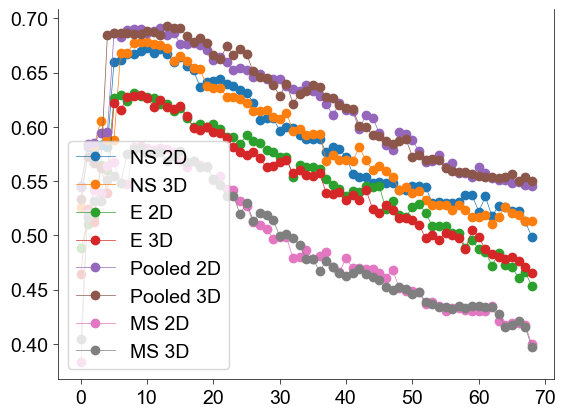

In [734]:
%%time

# setup resolution parameter grid
resolution_range = np.arange(0.1, 7, 0.1)

# find louvain resolution that maximizes modularity
# spont
best_resolution_ns_2d, modularities_ns_2d = find_best_resolution(single_site_templates_ns, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 2D
best_resolution_ns_3d, modularities_ns_3d = find_best_resolution(single_site_templates_ns, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D
# evoked
best_resolution_e_2d, modularities_e_2d = find_best_resolution(single_site_templates_e, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 3D
best_resolution_e_3d, modularities_e_3d = find_best_resolution(single_site_templates_e, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D
# pooled
best_resolution_pooled_2d, modularities_pooled_2d = find_best_resolution(single_site_templates, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 3D
best_resolution_pooled_3d, modularities_pooled_3d = find_best_resolution(single_site_templates, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D
# marques-smith
best_resolution_ms_2d, modularities_ms_2d = find_best_resolution(single_site_templates_ms, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 3D
best_resolution_ms_3d, modularities_ms_3d = find_best_resolution(single_site_templates_ms, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D

# plot
plt.plot(np.array(modularities_ns_2d), '-o', label='NS 2D');
plt.plot(np.array(modularities_ns_3d), '-o', label='NS 3D')
plt.plot(np.array(modularities_e_2d), '-o', label='E 2D')
plt.plot(np.array(modularities_e_3d), '-o', label='E 3D')
plt.plot(np.array(modularities_pooled_2d), '-o', label='Pooled 2D')
plt.plot(np.array(modularities_pooled_3d), '-o', label='Pooled 3D')
plt.plot(np.array(modularities_ms_2d), '-o', label='MS 2D')
plt.plot(np.array(modularities_ms_3d), '-o', label='MS 3D')
plt.legend()

# print best resolutions and max modularites
print('\Spont:')
print('2D - best resolution:', best_resolution_ns_2d)
print('max modularity:', max(modularities_ns_2d))
print('\n3D - best resolution:', best_resolution_ns_3d)
print('max modularity:', max(modularities_ns_3d))

print('\nEvoked:')
print('2D - best resolution:', best_resolution_e_2d)
print('max modularity:', max(modularities_e_2d))
print('\n3D - best resolution:', best_resolution_e_3d)
print('max modularity:', max(modularities_e_3d))

print('\nPooled:')
print('2D - best resolution:', best_resolution_pooled_2d)
print('max modularity:', max(modularities_pooled_2d))
print('\n3D - best resolution:', best_resolution_pooled_3d)
print('max modularity:', max(modularities_pooled_3d))

print('\nMS:')
print('2D - best resolution:', best_resolution_ms_2d)
print('max modularity:', max(modularities_ms_2d))
print('\n3D - best resolution:', best_resolution_ms_3d)
print('max modularity:', max(modularities_ms_3d))

#0.6930698171020095

#### Compute

In [736]:
# 2D 

# spont
normalized_singlesite_ns, umap_df_singlesite_ns, profiles_singlesite_ns, modularity = apply_wavemap(single_site_templates_ns, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_ns_2d, verbose=True)
# evoked 
normalized_singlesite_e, umap_df_singlesite_e, profiles_singlesite_e, modularity = apply_wavemap(single_site_templates_e, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_e_2d, verbose=True)
# pooled
normalized_singlesite, umap_df_singlesite, profiles_singlesite, modularity = apply_wavemap(single_site_templates, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_pooled_2d, verbose=True)
# marques-smith
normalized_singlesite_ms, umap_df_singlesite_ms, profiles_singlesite_ms, modularity = apply_wavemap(single_site_templates_ms, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_ms_2d, verbose=True)


# 3D 

# spont
normalized_singlesite_3D_ns, umap_df_singlesite_3D_ns, profiles_singlesite_3D_ns, modularity = apply_wavemap(single_site_templates_ns, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_ns_3d, verbose=True)
# evoked
normalized_singlesite_3D_e, umap_df_singlesite_3D_e, profiles_singlesite_3D_e, modularity = apply_wavemap(single_site_templates_e, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_e_3d, verbose=True)
# pooled
normalized_singlesite_3D, umap_df_singlesite_3D, profiles_singlesite_3D, modularity = apply_wavemap(single_site_templates, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_pooled_3d, verbose=True)
# marques-smith
normalized_singlesite_3D_ms, umap_df_singlesite_3D_ms, profiles_singlesite_3D_ms, modularity = apply_wavemap(single_site_templates_ms, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_ms_3d, verbose=True)

nb of shape profiles: 8
nb of shape profiles: 7
nb of shape profiles: 12
nb of shape profiles: 7
nb of shape profiles: 8
nb of shape profiles: 8
nb of shape profiles: 14
nb of shape profiles: 7


#### Plot

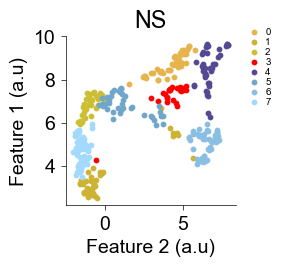

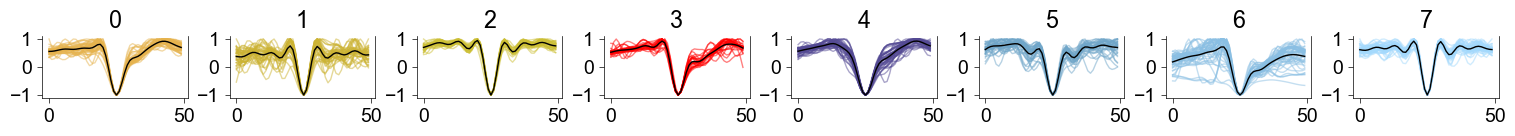

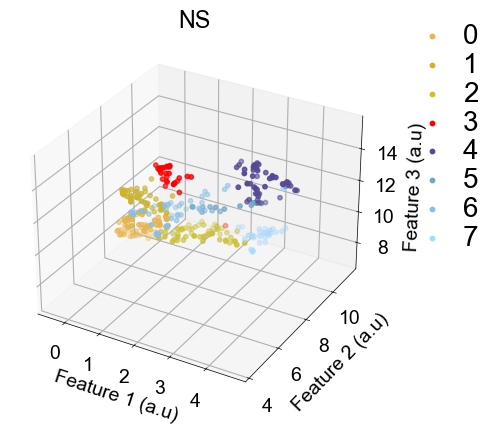

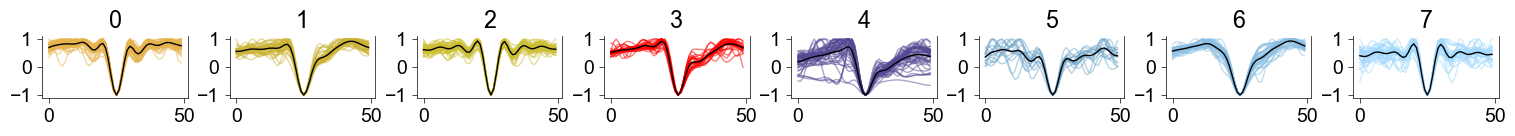

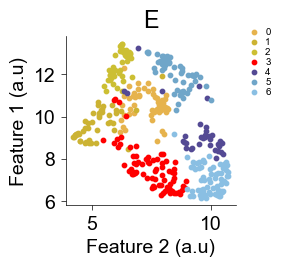

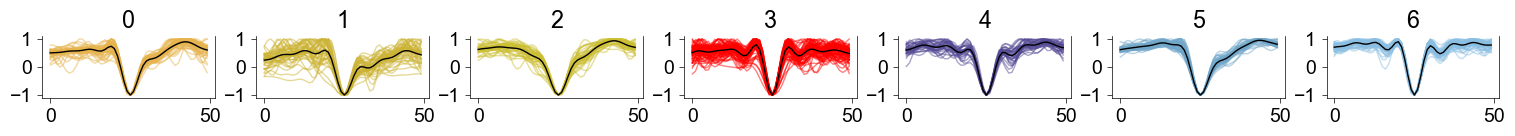

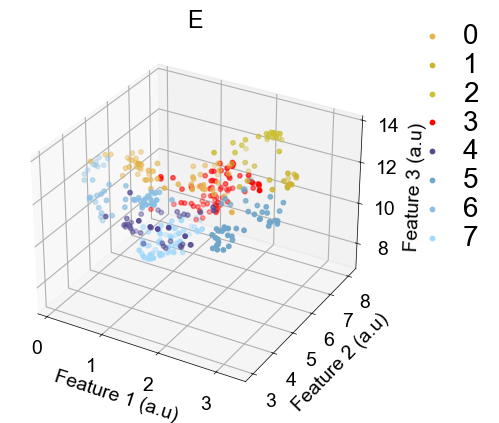

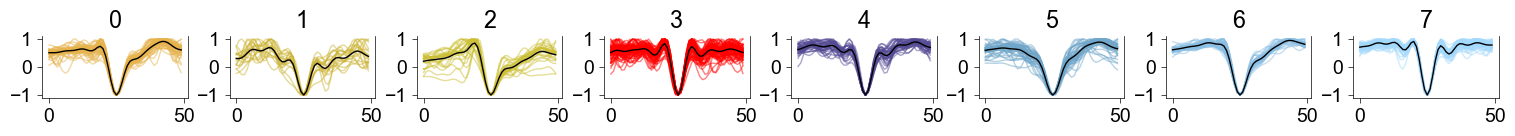

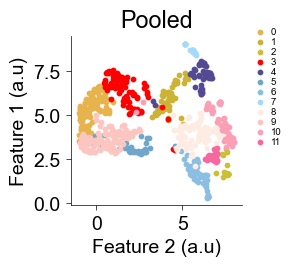

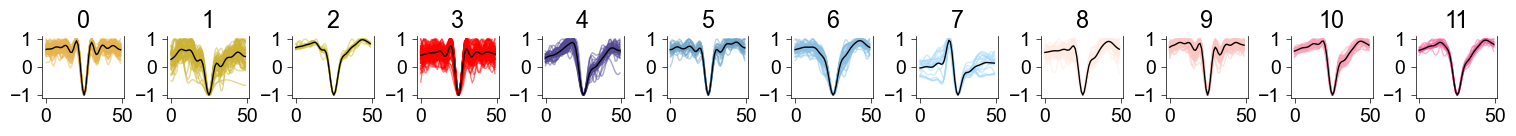

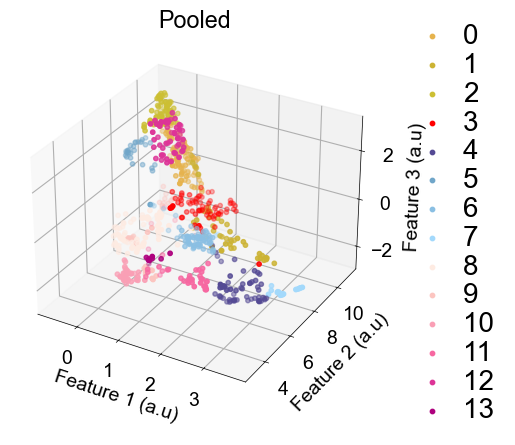

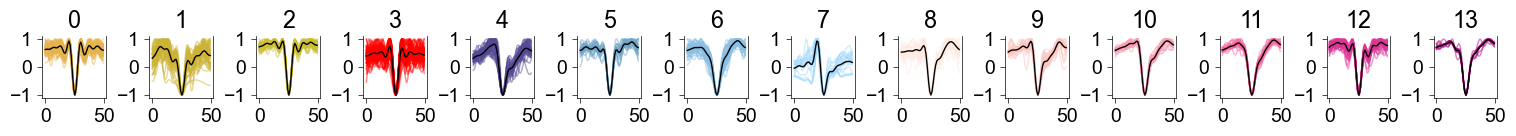

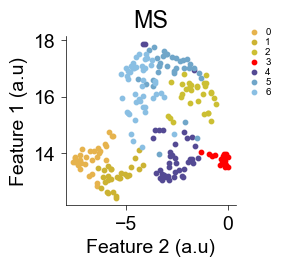

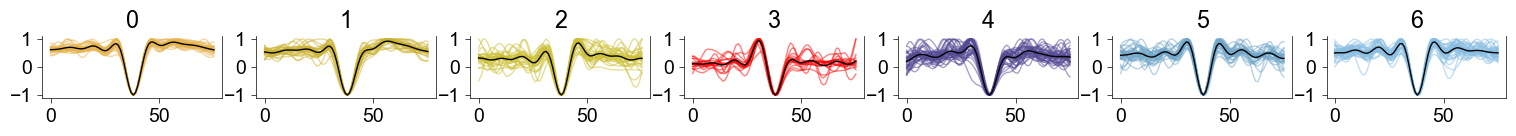

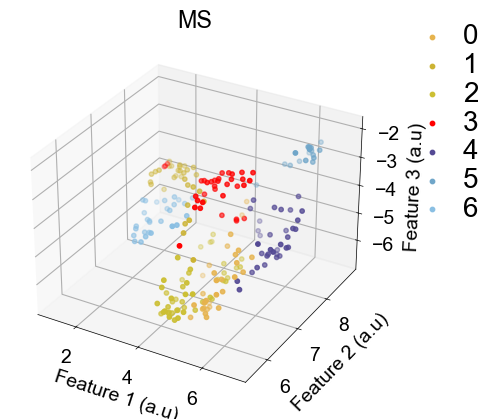

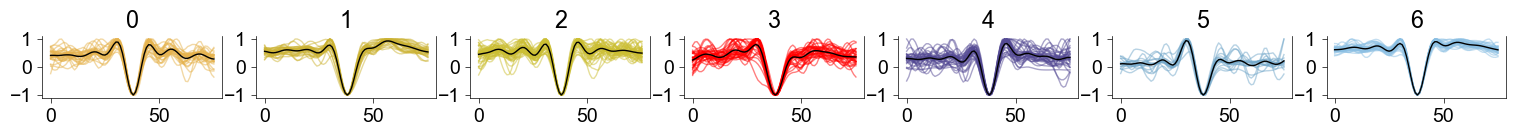

In [737]:
# SPONT ----------------------------------

# 2D 

# plot 
n_profiles = profiles_singlesite_ns[-1] + 1

# embeddings
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_singlesite_ns, profiles_singlesite_ns, colors)
ax.set_title('NS')
# profiles
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite_ns, umap_df_singlesite_ns, profiles_singlesite_ns, colors)
for cluster_id in profiles_singlesite_ns:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite_ns[umap_df_singlesite_ns['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)

# 3D

# plot 
n_profiles = profiles_singlesite_3D_ns[-1] + 1
# setup figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plot_embedding_3D(ax, umap_df_singlesite_3D_ns, profiles_singlesite_3D_ns, colors)
ax.set_title('NS')
# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite_3D_ns, umap_df_singlesite_3D_ns, profiles_singlesite_3D_ns, colors)
for cluster_id in profiles_singlesite_3D_ns:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite_3D_ns[umap_df_singlesite_3D_ns['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)


# EVOKED ----------------------------------


# 2D 

# plot 
n_profiles = profiles_singlesite_e[-1] + 1
# setup figure
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_singlesite_e, profiles_singlesite_e, colors)
ax.set_title('E')
# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite_e, umap_df_singlesite_e, profiles_singlesite_e, colors)
for cluster_id in profiles_singlesite_e:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite_e[umap_df_singlesite_e['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)

# 3D

# plot 
n_profiles = profiles_singlesite_3D_e[-1] + 1
# setup figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plot_embedding_3D(ax, umap_df_singlesite_3D_e, profiles_singlesite_3D_e, colors)
ax.set_title('E')
# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite_3D_e, umap_df_singlesite_3D_e, profiles_singlesite_3D_e, colors)
# average profiles
for cluster_id in profiles_singlesite_3D_e:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite_3D_e[umap_df_singlesite_3D_e['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)


# POOLED ----------------------------------


# 2D 

# plot 
n_profiles = profiles_singlesite[-1] + 1

# setup figure
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_singlesite, profiles_singlesite, colors)
ax.set_title('Pooled')
# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite, umap_df_singlesite, profiles_singlesite, colors)
# average profiles
for cluster_id in profiles_singlesite:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite[umap_df_singlesite['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)

# 3D

# plot 
n_profiles = profiles_singlesite_3D[-1] + 1

# setup figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plot_embedding_3D(ax, umap_df_singlesite_3D, profiles_singlesite_3D, colors)
ax.set_title('Pooled')
# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite_3D, umap_df_singlesite_3D, profiles_singlesite_3D, colors)
# average profiles
for cluster_id in profiles_singlesite_3D:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite_3D[umap_df_singlesite_3D['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)


# MARQUES-SMITH ----------------------------------


# 2D 

# plot 
n_profiles = profiles_singlesite_ms[-1] + 1
# setup figure
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
ax = plot_embedding(ax, umap_df_singlesite_ms, profiles_singlesite_ms, colors)
ax.set_title('MS')
# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite_ms, umap_df_singlesite_ms, profiles_singlesite_ms, colors)
for cluster_id in profiles_singlesite_ms:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite_ms[umap_df_singlesite_ms['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)

# 3D

# plot 
n_profiles = profiles_singlesite_3D_ms[-1] + 1
# setup figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plot_embedding_3D(ax, umap_df_singlesite_3D_ms, profiles_singlesite_3D_ms, colors)
ax.set_title('MS')
# setup figure
fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
ax = plot_profiles(ax, normalized_singlesite_3D_ms, umap_df_singlesite_3D_ms, profiles_singlesite_3D_ms, colors)
# average profiles
for cluster_id in profiles_singlesite_3D_ms:
    ax[cluster_id].plot(np.nanmean(normalized_singlesite_3D_ms[umap_df_singlesite_3D_ms['cluster_id']==cluster_id,:], axis=0), color='k', linewidth=1)
fig.tight_layout(pad=0.1)

### Multi-site

#### Best params

- tested n_neighbors=[2, 3, 5, 10, 15, 20]; n_dimensions = [2,3,5,10] ; resolution_range=[0.1:0.1:7]; n_sites=[4, 5, 6]
- We typically observe the highest modularity for n_dimensions=2 and the lowest n_neighbors values. Increasing dimensions tends to reduce modularity. Lower n_neighbors increases fine-grained clustering.
    - very small n_neighbor values such as 2 produced up to 70 clusters.
    - n_neighbors=3 -> reproduces all known types for MS and NS
    - n_neighbors=4 -> reproduces all known types for MS and NS
    - n_neighbors=7 -> reproduces all known types for MS and NS with less than 9 clusters
    - n_neighbors=10 -> reproduces all known types for MS and NS with less than 9 clusters
    - n_neighbors=15 -> NS does not find positive spikes.
    


\Spont:
2D - best resolution: 0.9
max modularity: 0.7844678899577996

Evoked:
2D - best resolution: 0.9
max modularity: 0.8072872928518049

Pooled:
2D - best resolution: 1.0
max modularity: 0.74588984454663

MS:
2D - best resolution: 0.9
max modularity: 0.6722628109036961
CPU times: user 10min 10s, sys: 14.2 s, total: 10min 24s
Wall time: 3min 18s


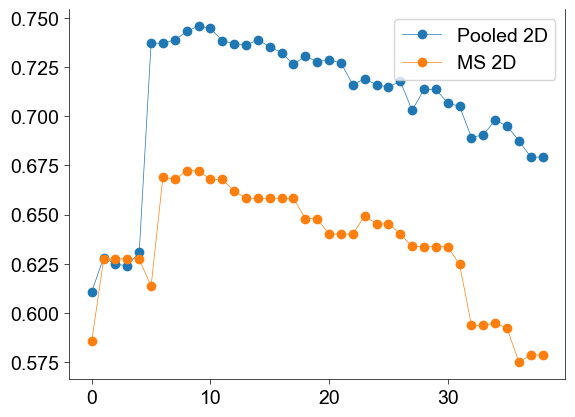

In [783]:
%%time

# setup parameters
N_NEIGHBORS = 6
resolution_range = np.arange(0.1, 4, 0.1)

# find louvain resolution that maximizes modularity
# # spont
# best_resolution_ns_2d, modularities_ns_2d = find_best_resolution(multi_sites_templates_ns, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 2D
# best_resolution_ns_3d, modularities_ns_3d = find_best_resolution(multi_sites_templates_ns, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D
# # evoked
# best_resolution_e_2d, modularities_e_2d = find_best_resolution(multi_sites_templates_e, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 3D
# best_resolution_e_3d, modularities_e_3d = find_best_resolution(multi_sites_templates_e, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D
# pooled
best_resolution_pooled_2d, modularities_pooled_2d = find_best_resolution(multi_sites_templates, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 3D
# best_resolution_pooled_3d, modularities_pooled_3d = find_best_resolution(multi_sites_templates, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D
# marques-smith
best_resolution_ms_2d, modularities_ms_2d = find_best_resolution(multi_sites_templates_ms, RAND_STATE, N_NEIGHBORS, 2, resolution_range, verbose=False) # 3D
# best_resolution_ms_3d, modularities_ms_3d = find_best_resolution(multi_sites_templates_ms, RAND_STATE, N_NEIGHBORS, 3, resolution_range, verbose=False) # 3D

# plot
# plt.plot(np.array(modularities_ns_2d), '-o', label='NS 2D');
# plt.plot(np.array(modularities_ns_3d), '-o', label='NS 3D')
# plt.plot(np.array(modularities_e_2d), '-o', label='E 2D')
# plt.plot(np.array(modularities_e_3d), '-o', label='E 3D')
plt.plot(np.array(modularities_pooled_2d), '-o', label='Pooled 2D')
# plt.plot(np.array(modularities_pooled_3d), '-o', label='Pooled 3D')
plt.plot(np.array(modularities_ms_2d), '-o', label='MS 2D')
# plt.plot(np.array(modularities_ms_3d), '-o', label='MS 3D')
plt.legend()

# print best resolutions and max modularites
print('\Spont:')
print('2D - best resolution:', best_resolution_ns_2d)
print('max modularity:', max(modularities_ns_2d))
# print('\n3D - best resolution:', best_resolution_ns_3d)
# print('max modularity:', max(modularities_ns_3d))

print('\nEvoked:')
print('2D - best resolution:', best_resolution_e_2d)
print('max modularity:', max(modularities_e_2d))
# print('\n3D - best resolution:', best_resolution_e_3d)
# print('max modularity:', max(modularities_e_3d))

print('\nPooled:')
print('2D - best resolution:', best_resolution_pooled_2d)
print('max modularity:', max(modularities_pooled_2d))
# print('3D - best resolution:', best_resolution_pooled_3d)
# print('max modularity:', max(modularities_pooled_3d))

print('\nMS:')
print('2D - best resolution:', best_resolution_ms_2d)
print('max modularity:', max(modularities_ms_2d))
# print('3D - best resolution:', best_resolution_ms_3d)
# print('max modularity:', max(modularities_ms_3d))

#### Compute

In [784]:
%%time

# 2D 

# spont
normalized_multisite_ns, umap_df_multisite_ns, profiles_multisite_ns, modularity = apply_wavemap(multi_sites_templates_ns, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_ns_2d, verbose=True)
# evoked 
normalized_multisite_e, umap_df_multisite_e, profiles_multisite_e, modularity = apply_wavemap(multi_sites_templates_e, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_e_2d, verbose=True)
# pooled
normalized_multisite, umap_df_multisite, profiles_multisite, modularity = apply_wavemap(multi_sites_templates, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_pooled_2d, verbose=True)
# marques-smith
normalized_multisite_ms, umap_df_multisite_ms, profiles_multisite_ms, modularity = apply_wavemap(multi_sites_templates_ms, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=2, resolution=best_resolution_ms_2d, verbose=True)



# 3D 

# spont
normalized_multisite_3D_ns, umap_df_multisite_3D_ns, profiles_multisite_3D_ns, modularity = apply_wavemap(multi_sites_templates_ns, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_ns_3d, verbose=True)
# evoked
normalized_multisite_3D_e, umap_df_multisite_3D_e, profiles_multisite_3D_e, modularity = apply_wavemap(multi_sites_templates_e, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_e_3d, verbose=True)
# pooled
normalized_multisite_3D, umap_df_multisite_3D, profiles_multisite_3D, modularity = apply_wavemap(multi_sites_templates, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_pooled_3d, verbose=True)
# marques-smith
normalized_multisite_3D_ms, umap_df_multisite_3D_ms, profiles_multisite_3D_ms, modularity = apply_wavemap(multi_sites_templates_ms, RAND_STATE, n_neighbors=N_NEIGHBORS, n_components=3, resolution=best_resolution_ms_3d, verbose=True)

nb of shape profiles: 10
nb of shape profiles: 8
nb of shape profiles: 14
nb of shape profiles: 7
nb of shape profiles: 12
nb of shape profiles: 9
nb of shape profiles: 14
nb of shape profiles: 7
CPU times: user 54 s, sys: 491 ms, total: 54.5 s
Wall time: 16.9 s


In [901]:
N_NEIGHBORS

15

#### Plot

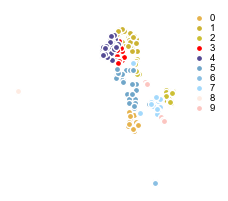

In [896]:
colors = np.array( # waveform shape profile colors
    [
        [0.9, 0.7, 0.3],  # yellow/gold
        [0.8, 0.70, 0.2],  # lighter yellow/green
        [0.8, 0.75, 0.2],  # lightest yellow/green
        [1, 0, 0],  # red
        [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        [0.64, 0.85, 0.99],  # lightest blue
        [254 / 255, 235 / 255, 226 / 255],  # purple variation
        [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
    ]
)

# plot spont. embeddings (2D)
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
n_profiles = profiles_multisite_ns[-1] + 1
ax = plot_embedding(ax, umap_df_multisite_ns, profiles_multisite_ns, colors)
ax.axis('off')

# save figures
plt.savefig("figures/7_reviews/fig3_H_wavemap_embedding_npx_spont.svg", **savefig_cfg)


cluster_id
0    26
1    42
2    29
3    19
4    41
5    31
6     5
7    22
8     4
9     9
Name: count, dtype: int64

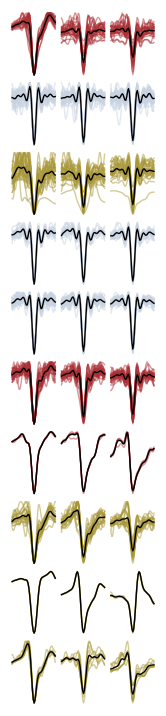

In [897]:
# colors = [red, blue2, red, blue, blue, gold, blue]
# each_colors = [each_red, each_blue2, each_red, each_blue, each_blue2, each_gold, each_blue2]
colors = [red, blue2, gold, blue2, blue2, red, red, gold, gold, gold]
each_colors = [each_red, each_blue2, each_gold, each_blue2, each_blue2, each_red, each_red, each_gold, each_gold, each_gold]


# setup plot of clusters
fig, axes = plt.subplots(n_profiles, 3, figsize=(1.5,7))

# nearest site
ax = plot_profiles(axes[:,0], normalized_multisite_ns[:,:50], umap_df_multisite_ns, profiles_multisite_ns, each_colors, is_title=False, is_ylabel=True)
for cluster_id in profiles_multisite_ns:
    ax[cluster_id].plot(np.nanmean(normalized_multisite_ns[umap_df_multisite_ns['cluster_id']==cluster_id,:50], axis=0), color='k', linewidth=1)
    ax[cluster_id].axis('off')

# 2nd nearest site
ax = plot_profiles(axes[:,1], normalized_multisite_ns[:,50:100], umap_df_multisite_ns, profiles_multisite_ns, each_colors, is_title=False, is_ylabel=False)
for cluster_id in profiles_multisite_ns:
    ax[cluster_id].plot(np.nanmean(normalized_multisite_ns[umap_df_multisite_ns['cluster_id']==cluster_id,50:100], axis=0), color='k', linewidth=1)
    ax[cluster_id].axis('off')

# 3rd nearest site
ax = plot_profiles(axes[:,2], normalized_multisite_ns[:,100:150], umap_df_multisite_ns, profiles_multisite_ns, each_colors, is_title=False, is_ylabel=False)
for cluster_id in profiles_multisite_ns:
    ax[cluster_id].plot(np.nanmean(normalized_multisite_ns[umap_df_multisite_ns['cluster_id']==cluster_id,100:150], axis=0), color='k', linewidth=1)
    ax[cluster_id].axis('off')

fig.tight_layout(pad=0.1)

# save figures
plt.savefig("figures/7_reviews/fig3_H_wavemap_clusters_npx_spont.svg", **savefig_cfg)

umap_df_multisite_ns.value_counts('cluster_id', sort=False)

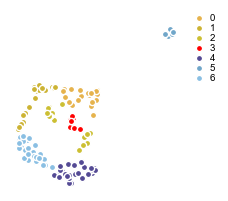

In [892]:
colors = np.array( # waveform shape profile colors
    [
        [0.9, 0.7, 0.3],  # yellow/gold
        [0.8, 0.70, 0.2],  # lighter yellow/green
        [0.8, 0.75, 0.2],  # lightest yellow/green
        [1, 0, 0],  # red
        [0.33, 0.29, 0.58],  # purple blue
        [0.44, 0.65, 0.79],  # light blue
        [0.54, 0.75, 0.89],  # lighter blue
        [0.64, 0.85, 0.99],  # lightest blue
        [254 / 255, 235 / 255, 226 / 255],  # purple variation
        [252 / 255, 197 / 255, 192 / 255],  # purple variation
        [250 / 255, 159 / 255, 181 / 255],  # purple variation
    ]
)

# plot marques-smith embeddings (2D)
fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
n_profiles = profiles_multisite_ms[-1] + 1
ax = plot_embedding(ax, umap_df_multisite_ms, profiles_multisite_ms, colors)
ax.axis('off')

# save figures
plt.savefig("figures/7_reviews/fig3_G_wavemap_embedding_marques.svg", **savefig_cfg)

cluster_id
0    19
1    19
2    15
3     8
4    27
5     8
6    26
Name: count, dtype: int64

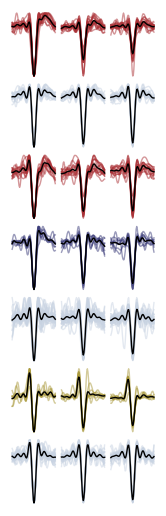

In [894]:
# MARQUES-SMITH ----------------------------------

colors = [red, blue2, red, blue, blue, gold, blue]
each_colors = [each_red, each_blue2, each_red, each_blue, each_blue2, each_gold, each_blue2]

# setup plot of clusters
fig, axes = plt.subplots(n_profiles, 3, figsize=(1.5,5))

# nearest site
ax = plot_profiles(axes[:,0], normalized_multisite_ms[:,:76], umap_df_multisite_ms, profiles_multisite_ms, each_colors, is_title=False, is_ylabel=True)
for cluster_id in profiles_multisite_ms:
    ax[cluster_id].plot(np.nanmean(normalized_multisite_ms[umap_df_multisite_ms['cluster_id']==cluster_id,:76], axis=0), color='k', linewidth=1)
    ax[cluster_id].axis('off')

# 2nd nearest site
ax = plot_profiles(axes[:,1], normalized_multisite_ms[:,76:2*76], umap_df_multisite_ms, profiles_multisite_ms, each_colors, is_title=False, is_ylabel=False)
for cluster_id in profiles_multisite_ms:
    ax[cluster_id].plot(np.nanmean(normalized_multisite_ms[umap_df_multisite_ms['cluster_id']==cluster_id,76:2*76], axis=0), color='k', linewidth=1)
    ax[cluster_id].axis('off')

# 3rd nearest site
ax = plot_profiles(axes[:,2], normalized_multisite_ms[:,2*76:3*76], umap_df_multisite_ms, profiles_multisite_ms, each_colors, is_title=False, is_ylabel=False)
for cluster_id in profiles_multisite_ms:
    ax[cluster_id].plot(np.nanmean(normalized_multisite_ms[umap_df_multisite_ms['cluster_id']==cluster_id,2*76:3*76], axis=0), color='k', linewidth=1)
    ax[cluster_id].axis('off')

fig.tight_layout(pad=0.1)

# save figures
plt.savefig("figures/7_reviews/fig3_G_wavemap_clusters_marques.svg", **savefig_cfg)

umap_df_multisite_ms.value_counts('cluster_id', sort=False)

#### Supplementary

In [ ]:
# SPONT --------------------------------------

# # 3D

# # plot 
# n_profiles = profiles_multisite_3D_ns[-1] + 1
# # setup figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax = plot_embedding_3D(ax, umap_df_multisite_3D_ns, profiles_multisite_3D_ns, colors)
# ax.set_title('NS')
# # setup figure
# fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
# ax = plot_profiles(ax, normalized_multisite_3D_ns[:,:50], umap_df_multisite_3D_ns, profiles_multisite_3D_ns, colors)
# for cluster_id in profiles_multisite_3D_ns:
#     ax[cluster_id].plot(np.nanmean(normalized_multisite_3D_ns[umap_df_multisite_3D_ns['cluster_id']==cluster_id,:50], axis=0), color='k', linewidth=1)
# fig.tight_layout(pad=0.1)


# # EVOKED ----------------------------------


# # 2D 

# # plot 
# n_profiles = profiles_multisite_e[-1] + 1
# # setup figure
# fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
# ax = plot_embedding(ax, umap_df_multisite_e, profiles_multisite_e, colors)
# ax.set_title('E')
# # setup figure
# fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
# ax = plot_profiles(ax, normalized_multisite_e[:,:50], umap_df_multisite_e, profiles_multisite_e, colors)
# for cluster_id in profiles_multisite_e:
#     ax[cluster_id].plot(np.nanmean(normalized_multisite_e[umap_df_multisite_e['cluster_id']==cluster_id,:50], axis=0), color='k', linewidth=1)
# fig.tight_layout(pad=0.1)

# # 3D

# # plot 
# n_profiles = profiles_multisite_3D_e[-1] + 1
# # setup figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax = plot_embedding_3D(ax, umap_df_multisite_3D_e, profiles_multisite_3D_e, colors)
# ax.set_title('E')
# # setup figure
# fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
# ax = plot_profiles(ax, normalized_multisite_3D_e[:,:50], umap_df_multisite_3D_e, profiles_multisite_3D_e, colors)
# # average profiles
# for cluster_id in profiles_multisite_3D_e:
#     ax[cluster_id].plot(np.nanmean(normalized_multisite_3D_e[umap_df_multisite_3D_e['cluster_id']==cluster_id,:50], axis=0), color='k', linewidth=1)
# fig.tight_layout(pad=0.1)


# POOLED ------------------------------------


# 2D 

# # plot 
# n_profiles = profiles_multisite[-1] + 1

# # setup figure
# fig, ax = plt.subplots(1, figsize=(2.2, 2.2))
# ax = plot_embedding(ax, umap_df_multisite, profiles_multisite, colors)
# ax.set_title('Pooled')
# # setup figure
# fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
# ax = plot_profiles(ax, normalized_multisite[:,:50], umap_df_multisite, profiles_multisite, colors)
# # average profiles
# for cluster_id in profiles_multisite:
#     ax[cluster_id].plot(np.nanmean(normalized_multisite[umap_df_multisite['cluster_id']==cluster_id,:50], axis=0), color='k', linewidth=1)
# fig.tight_layout(pad=0.1)

# # 3D

# # plot 
# n_profiles = profiles_multisite_3D[-1] + 1

# # setup figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax = plot_embedding_3D(ax, umap_df_multisite_3D, profiles_multisite_3D, colors)
# ax.set_title('Pooled')
# # setup figure
# fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
# ax = plot_profiles(ax, normalized_multisite_3D[:,:50], umap_df_multisite_3D, profiles_multisite_3D, colors)
# # average profiles
# for cluster_id in profiles_multisite_3D:
#     ax[cluster_id].plot(np.nanmean(normalized_multisite_3D[umap_df_multisite_3D['cluster_id']==cluster_id,:50], axis=0), color='k', linewidth=1)
# fig.tight_layout(pad=0.1)

# MARQUES_SMITH ------------------------------------

# 3D

# # plot 
# n_profiles = profiles_multisite_3D_ms[-1] + 1

# # setup figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax = plot_embedding_3D(ax, umap_df_multisite_3D_ms, profiles_multisite_3D_ms, colors)
# ax.set_title('MS')
# # setup figure
# fig, ax = plt.subplots(1, n_profiles, figsize=(15, 1.2))
# ax = plot_profiles(ax, normalized_multisite_3D_ms[:,:76], umap_df_multisite_3D_ms, profiles_multisite_3D_ms, colors)
# # average profiles
# for cluster_id in profiles_multisite_3D_ms:
#     ax[cluster_id].plot(np.nanmean(normalized_multisite_3D_ms[umap_df_multisite_3D_ms['cluster_id']==cluster_id,:76], axis=0), color='k', linewidth=1)
# fig.tight_layout(pad=0.1)

## Plot spike shape clusters

as fig3 Paulk Nat Neurosci 2022

- first site (column) is the site with the largest peak to peak amplitude
- Second site (column) is the site with the second largest peak to peak amplitude

2025-04-07 14:38:54,816 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,915 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,940 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38:54,976 - matplotlib.legend - legend.py - _parse_legend_args - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2025-04-07 14:38

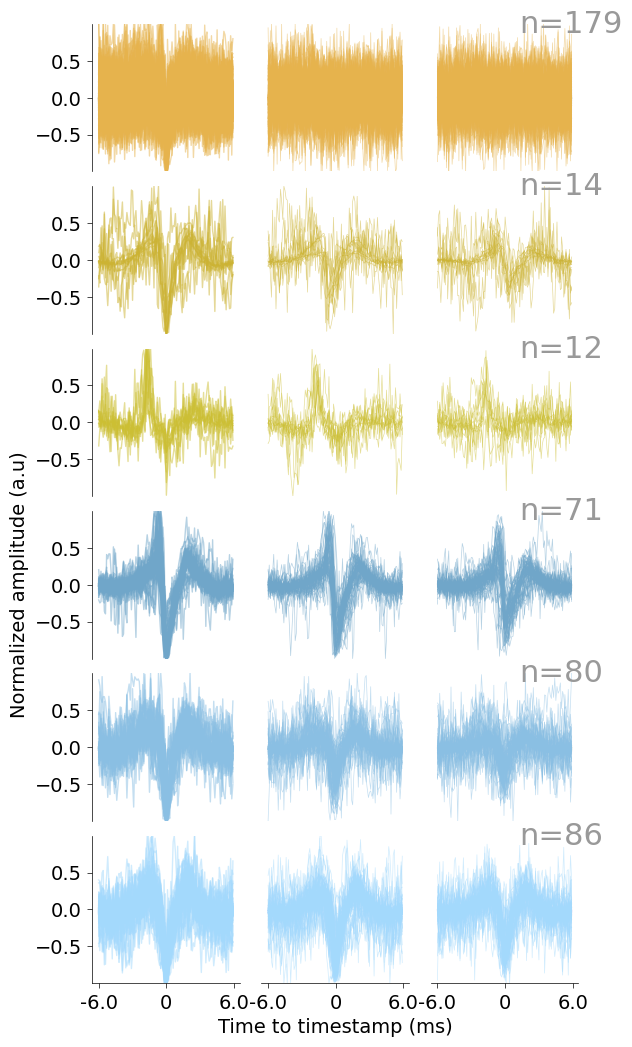

In [ ]:
# %%time 

# counts = Counter(umap_df["cluster_id"])

# # order cluster profile panels
# profiles = [3, 5, 4, 1, 0, 2]

# # spike timestamp locatoon
# timestamp_timepoint = SPIKE_PERIOD / 2

# # setup figure
# fig, axes = plt.subplots(len(profiles), 3, figsize=(5 * 1.5, 7 * 1.5))

# YLIM = [-1, 1]

# # loop over waveform clusters
# for ix, profile_i in enumerate(profiles):

#     # site 1
#     axes[ix, 0].plot(
#         normWFs[umap_df["cluster_id"] == profile_i, :SPIKE_PERIOD].T,
#         color=colors[ix],
#         alpha=0.5,
#         linewidth=1,
#     )
#     axes[ix, 0].set_box_aspect(1)  # square axis
#     axes[ix, 0].spines[["top", "right"]].set_visible(False)
#     if not ix == len(profiles) - 1:
#         axes[ix, 0].spines[["bottom"]].set_visible(False)
#     axes[ix, 0].legend(frameon=False)
#     axes[ix, 0].set_yticks([-0.5, 0, 0.5])
#     axes[ix, 0].set_ylim(YLIM)
#     if ix == 3:
#         axes[ix, 0].set_ylabel("Normalized amplitude (a.u)")
#     axes[ix, 0].set_xticks([])
#     axes[ix, 0].set_xticklabels([])
#     if ix == len(profiles) - 1:
#         axes[ix, 0].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
#         axes[ix, 0].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])

#     # site 2
#     axes[ix, 1].plot(
#         normWFs[umap_df["cluster_id"] == profile_i, SPIKE_PERIOD : 2 * SPIKE_PERIOD].T,
#         color=colors[ix],
#         alpha=0.5,
#         linewidth=0.5,
#     )
#     axes[ix, 1].set_box_aspect(1)  # square axis$
#     axes[ix, 1].spines[["top", "right"]].set_visible(False)
#     if not ix == len(profiles) - 1:
#         axes[ix, 0].spines[["bottom"]].set_visible(False)
#     axes[ix, 1].set_yticks([-0.5, 0, 0.5])
#     axes[ix, 1].set_ylim(YLIM)
#     axes[ix, 1].spines[["left", "right", "top"]].set_visible(False)
#     if not ix == len(profiles) - 1:
#         axes[ix, 1].spines[["bottom"]].set_visible(False)
#     axes[ix, 1].set_yticklabels([])
#     axes[ix, 1].set_yticks([])
#     axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
#     axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
#     axes[ix, 1].set_xticks([])
#     axes[ix, 1].set_xticklabels([])
#     if ix == len(profiles) - 1:
#         axes[ix, 1].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
#         axes[ix, 1].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
#         axes[ix, 1].set_xlabel("Time to timestamp (ms)")

#     # site 3
#     axes[ix, 2].plot(
#         normWFs[
#             umap_df["cluster_id"] == profile_i, 2 * SPIKE_PERIOD : 3 * SPIKE_PERIOD
#         ].T,
#         color=colors[ix],
#         alpha=0.5,
#         linewidth=0.5,
#     )
#     axes[ix, 2].set_box_aspect(1)  # square axis
#     axes[ix, 2].set_yticks([-0.5, 0, 0.5])
#     axes[ix, 2].set_ylim(YLIM)
#     axes[ix, 2].spines[["left", "right", "top"]].set_visible(False)
#     if not ix == len(profiles) - 1:
#         axes[ix, 2].spines[["bottom"]].set_visible(False)
#     axes[ix, 2].set_yticklabels([])
#     axes[ix, 2].set_yticks([])
#     axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
#     axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
#     axes[ix, 2].set_xticks([])
#     axes[ix, 2].set_xticklabels([])
#     if ix == len(profiles) - 1:
#         axes[ix, 2].set_xticks([0, timestamp_timepoint, SPIKE_PERIOD])
#         axes[ix, 2].set_xticklabels([-MS_BEFORE, 0, MS_AFTER])
#     axes[ix, 2].annotate(
#         "n=" + str(counts[profile_i]),
#         xy=(0.6, 0.9),
#         xycoords="axes fraction",
#         horizontalalignment="left",
#         verticalalignment="bottom",
#         color=(0.6, 0.6, 0.6),
#         fontsize=22,
#     )

# fig.tight_layout(**tight_layout_cfg)
# fig.subplots_adjust(wspace=-0.45, hspace=0.1)